In [59]:
%load_ext autoreload
%autoreload 2
import sys
import cocpit
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
import dask.array as da
from dask import dataframe as dd
import dask
import glob
from scipy import stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
cluster = SLURMCluster(
    queue='kratos',
    walltime='04-23:00:00',
    cores=1,
    memory='2000MiB', #1 GiB = 1,024 MiB
    processes=1)

cluster.scale(10)
#cluster.adapt(minimum=3, maximum=20)

/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [61]:
client = Client(cluster)

In [67]:
client

Client Scheduler: tcp://169.226.65.175:41119 Dashboard: http://169.226.65.175:33181/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [ ]:
#Dont run the next cell!

In [64]:
files = glob.glob('../instance_files/createdb_iceagg_flat*')
for file in files:
    print(file)
    df = pd.read_pickle(file)
    df = pd.DataFrame(df)
    df[['ncrystals', 'mono_phi', 'mono_r', 'a', 'b', 'c', 'phi2D', 'cplx']].to_parquet('../instance_files/parquet_files/'+file.split('/')[-1],\
                                                              compression='gzip')
    print('done transfering %s to parquet' %file)

../instance_files/createdb_iceagg_flat_r500_1000
         ncrystals                                             points  \
0                2  [[[609.3168846558945, 2841.225399434261, -58.1...   
1                3  [[[-314.1368938531092, 2646.565911675529, -75....   
2                4  [[[-1510.1563531296806, 2476.878524143153, -99...   
3                5  [[[-2297.0369445518168, 1530.1543947174962, -1...   
4                6  [[[-1879.721426214385, -2111.4272124807603, -1...   
...            ...                                                ...   
1043995         26  [[[29176.536770846098, 11806.595795349891, -75...   
1043996         27  [[[10056.310228445707, 29991.14235871538, -789...   
1043997         28  [[[-28299.98443865677, 19151.661580624634, -79...   
1043998         29  [[[-33356.34893814161, -446.8517115520434, -83...   
1043999         30  [[[-2278.9958494834445, -34875.399464246286, -...   

                    a             b            c      cplx     phi2D  \
0 

In [10]:
%%time
ddf = dd.read_parquet("../instance_files/parquet_files/*", engine="pyarrow").compute()

CPU times: user 649 ms, sys: 1.64 s, total: 2.29 s
Wall time: 15.2 s


In [16]:
f = open('../instance_files/instance_iceagg_rand_n30_r10_verify_perim', 'rb')
#monomer aspect ratios = [0.01, 0.25, 0.5, 1.0, 2.0, 4.0, 10., 100]
results = pickle.load(f)
agg_as, agg_bs, agg_cs, phi2Ds, phi2D, cplxs, dds, perims= \
                results[0], results[1], results[2], results[3], \
                results[4], results[5], results[6], results[7]
f.close()

In [11]:
ddf['agg_phi'] = ddf['c']/ddf['a']
ddf.agg_phi.describe().round(3)

count    4872000.000
mean           0.488
std            0.133
min            0.005
25%            0.405
50%            0.490
75%            0.576
max            0.975
Name: agg_phi, dtype: float64

In [12]:
#read in CPI data 
#all campaings in one file
df_CPI = pd.read_csv('df_IPAS_ellipse_aggs_allcampaigns.csv')
#only use aggregates
#df_CPI = df_CPI[(df_CPI['classification'] == 'agg')]

In [13]:
df_nonan = df_CPI[df_CPI['IPAS_ellipse'].notnull()]
df_nonan.head()

,campaign,filename,height,width,lapl,contours,edges,std,cnt_area,contrast,...,column,compact irregular,fragment,needle,plate,rimed agg,rimed column,sphere,classification,IPAS_ellipse
0,ARM,0113-003923_258_106.png,73,146,40.049258,7,59095,253.199225,116445.0,79.919408,...,0.001641,1.095366,8.579218,1.927986e-03,0.652817,0.000566,0.000170,6.867780e-04,agg,0.742626
6,ARM,0112-232751_345_54.png,251,220,22.808036,1,44062,262.644530,437353.0,74.211622,...,0.005742,34.481544,0.000294,5.774467e-08,0.001914,12.303793,0.028063,1.794255e-09,agg,0.680937
8,ARM,0113-013601_977_91.png,254,291,87.025100,106,173212,289.100042,235543.0,79.993680,...,1.210635,0.170934,0.405709,1.091572e+00,0.000438,0.828844,2.327764,1.769497e-04,agg,0.382877
10,ARM,0113-011602_142_3.png,180,162,35.827668,1,64259,253.751984,384837.0,84.741267,...,0.000018,23.062397,0.000065,1.291213e-08,0.000093,0.001267,0.000014,1.604917e-11,agg,0.746327
11,ARM,0309-205611_157_34.png,172,186,23.741574,3,52998,234.483460,374223.5,76.377069,...,0.000015,0.030816,0.000756,3.078992e-08,0.000070,44.301258,0.053570,7.613914e-11,agg,0.812108


In [14]:
truncall = ddf[(ddf['mono_phi'] < 50)]
trunc20 = ddf[(ddf['mono_phi'] < 50) & (ddf['ncrystals'] < 20)]
trunc10 = ddf[(ddf['mono_phi'] < 50) & (ddf['ncrystals'] < 10)]

In [57]:
stats.mode(trunc10['agg_phi']), stats.mode(trunc20['agg_phi']), stats.mode(truncall['agg_phi'])

(ModeResult(mode=array([0.00953017]), count=array([1])),
 ModeResult(mode=array([0.00953017]), count=array([1])),
 ModeResult(mode=array([0.00953017]), count=array([1])))

In [ ]:
np.mean(trunc10['agg_phi']), stats.mean(trunc20['agg_phi']), stats.mean(truncall['agg_phi'])

In [16]:
large = 20; med = 16; small = 14
params = {'axes.titlesize': large,
          'legend.fontsize': small,
          'figure.figsize': (7,7),
          'axes.labelsize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large,
          "font.family": "serif"}
plt.rcParams.update(params)

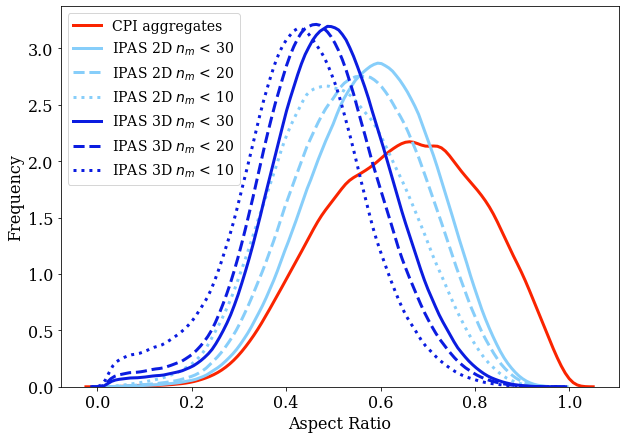

In [35]:
fig, ax = plt.subplots(figsize=(10,7))
sns.distplot(df_nonan['IPAS_ellipse'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3,'color':'#FA2400'}, label='CPI aggregates')

# sns.distplot(df_nonan['phi_ellipse'], hist = False, kde = True, norm_hist=True,
#              kde_kws = {'linewidth': 3,'color':'red'}, label='CPI (opencv ellipse)')

sns.distplot(truncall['phi2D'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3,'color':'lightskyblue'}, label='IPAS 2D $n_m$ < 30')

sns.distplot(trunc20['phi2D'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle':'--','color':'lightskyblue'}, label='IPAS 2D $n_m$ < 20')

sns.distplot(trunc10['phi2D'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle':':','color':'lightskyblue'}, label='IPAS 2D $n_m$ < 10')

sns.distplot(truncall['agg_phi'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3,'color':'#0B1CE0'}, label='IPAS 3D $n_m$ < 30')

sns.distplot(trunc20['agg_phi'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle':'--','color':'#0B1CE0'}, label='IPAS 3D $n_m$ < 20')

sns.distplot(trunc10['agg_phi'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle':':','color':'#0B1CE0'}, label='IPAS 3D $n_m$ < 10')

ax.set(xlabel='Aspect Ratio', ylabel='Frequency');
plt.savefig('../plots/CPI_IPAS_phi_distributions.png', dpi=300)

In [34]:
df_CPI[(df_CPI['classification'] == 'needle') & (df_CPI['phi_ellipse']== 0.020406091372841943)].campaign

479478    OLYMPEX
Name: campaign, dtype: object

In [28]:
1/df_CPI[df_CPI['classification'] == 'needle'].phi.describe()

count     0.000225
mean      3.930941
std       6.969441
min      17.823526
25%       5.709294
50%       4.606064
75%       3.512944
max       1.000000
Name: phi, dtype: float64

In [37]:
1/df_CPI[df_CPI['classification'] == 'needle'].phi_ellipse.describe()

count     0.000225
mean      4.600283
std       8.017075
min      49.004975
25%       7.184571
50%       5.448759
75%       3.918159
max       1.065896
Name: phi_ellipse, dtype: float64

KeyboardInterrupt: 

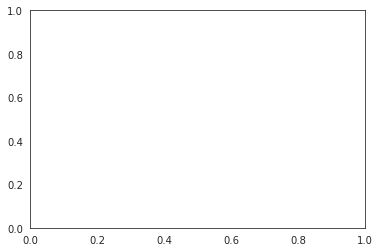

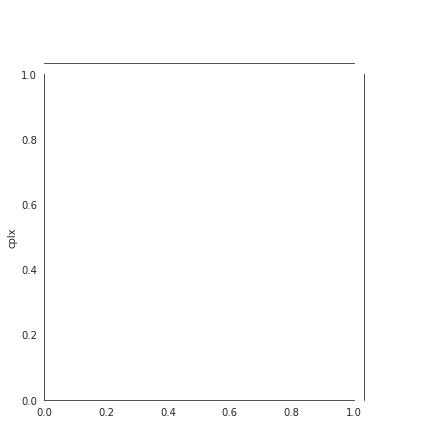

In [17]:
fig, ax = plt.subplots()
sns.set_style("white")
sns.jointplot(df_trunc['a'].compute()/df_trunc['c'].compute(),df_trunc['cplx'].compute(), kind='kde', ax=ax, shade=False)
ax.set_ylim(0.0,1.0)
ax.set_xlim(0.0,1.0)
ax2 = ax.twinx()
sns.jointplot(df_CPI['phi_ellipse'], df_CPI['complexity'], kind='kde', color='r', ax=ax2, shade=False)
ax2.set_ylim(0.0,1.0)
ax2.set_xlim(0.0,1.0)

# Only aggregates

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Aspect Ratio')]

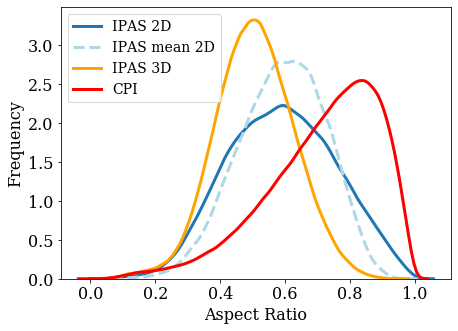

In [223]:
#phi2D and phi2Ds from 0.25-10.0, 30 monomers, r_m = 10
#agg_phi, 3D from database from 0.25-10.0, 30 monomers, all r_m
fig, ax = plt.subplots(figsize=(7,5))

sns.distplot(phi2D[1:-1,:,:,:].flatten(), hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='IPAS 2D')
sns.distplot(phi2Ds[1:-1,:,:,:].flatten(), hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle': '--', 'color': 'lightblue'}, label='IPAS mean 2D')
sns.distplot(ddf['agg_phi'][(ddf['mono_phi'] <= 10.0) & (ddf['mono_phi'] >= 0.25)], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'color': 'orange'}, label='IPAS 3D')
sns.distplot(df_CPI['phi_ellipse'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'color':'red'}, label='CPI')
ax.set(xlabel='Aspect Ratio', ylabel='Frequency')


[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Aspect Ratio')]

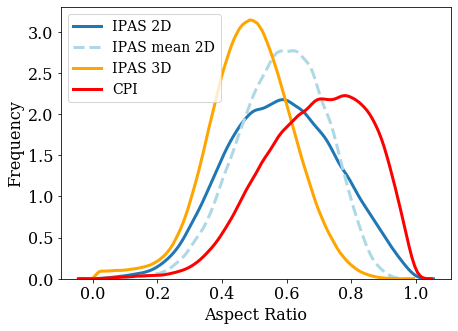

In [78]:
#phi2D and phi2Ds from 0.01-100.0, 30 monomers, r_m = 10
#agg_phi, 3D from database from 0.01-100.0, 30 monomers, all r_m
fig, ax = plt.subplots(figsize=(7,5))

sns.distplot(phi2D.flatten(), hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='IPAS 2D')
sns.distplot(phi2Ds.flatten(), hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle': '--', 'color': 'lightblue'}, label='IPAS mean 2D')
sns.distplot(ddf['agg_phi'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'color': 'orange'}, label='IPAS 3D')
sns.distplot(df_CPI['phi_ellipse'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'color':'red'}, label='CPI')
ax.set(xlabel='Aspect Ratio', ylabel='Frequency')


truncating the database to 0.25-10 doesn't change the overall distributions for 2D or 3D aspect ratios

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Complexity')]

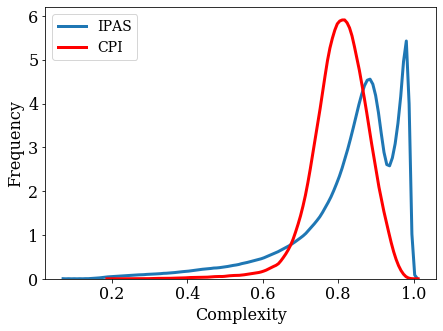

In [27]:
#all IPAS aggs from database no truncation
#needles responsible for secondary max
fig, ax = plt.subplots(figsize=(7,5))

sns.distplot(ddf['cplx'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='IPAS')
sns.distplot(df_CPI['complexity'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'color':'red'}, label='CPI')
ax.set(xlabel='Complexity', ylabel='Frequency')

In [146]:
trunc = ddf[(ddf['mono_phi'] > 0.01) & (ddf['mono_phi'] < 50)]
#looked at CPI needle max aspect ratios to know where to truncate

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Complexity')]

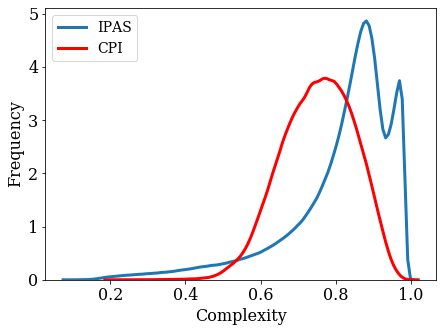

In [83]:
fig, ax = plt.subplots(figsize=(7,5))
sns.distplot(trunc['cplx'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='IPAS')
sns.distplot(df_CPI['complexity'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'color':'red'}, label='CPI')
ax.set(xlabel='Complexity', ylabel='Frequency')

CPI aggregates a little less complex 

CPI data looks more quasi-spherical in terms of aspect ratios: add in other particle types, not just aggs

# All CPI particle types

In [148]:
#read in CPI data 
#all campaings in one file
df_CPI = pd.read_csv('final_databases/no_mask/all_campaigns.csv')
df_CPI = df_CPI[df_CPI['classification'] != 'blank']

In [149]:
len(df_CPI), len(ddf), len(phi2D.flatten())

(505565, 4872000, 69600)

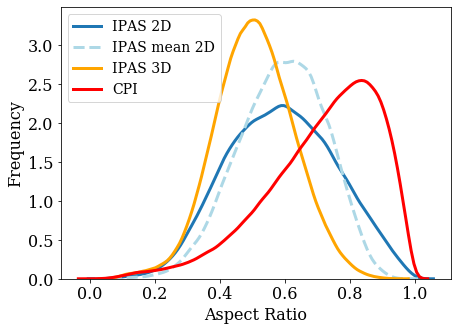

In [150]:
#phi2D and phi2Ds from 0.25-10.0, 30 monomers, r_m = 10
#agg_phi, 3D from database from 0.25-10.0, 30 monomers, all r_m
fig, ax = plt.subplots(figsize=(7,5))

sns.distplot(phi2D[1:-1,:,:,:].flatten(), hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='IPAS 2D')
sns.distplot(phi2Ds[1:-1,:,:,:].flatten(), hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle': '--', 'color': 'lightblue'}, label='IPAS mean 2D')
sns.distplot(ddf['agg_phi'][(ddf['mono_phi'] <= 10.0) & (ddf['mono_phi'] >= 0.25)], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'color': 'orange'}, label='IPAS 3D')
sns.distplot(df_CPI['phi_ellipse'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'color':'red'}, label='CPI')
ax.set(xlabel='Aspect Ratio', ylabel='Frequency');

array([0.7602096])

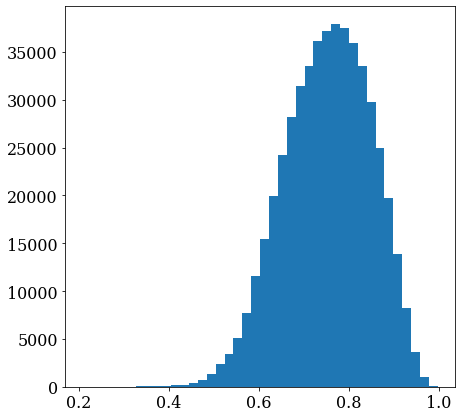

In [155]:
n, bins, patches = plt.hist(df_CPI['complexity'], bins = 40)
bins[np.where(n == n.max())]  #max CPI aspect ratio from ellipse (not averaged)

In [ ]:
#mode of complexity histogram only dropped by 0.035 including all particle types

In [157]:
#play around with specific particle types
df_CPI['classification'].unique()

array(['needle', 'agg', 'bullet', 'fragment', 'compact irregular',
       'plate', 'budding', 'rimed agg', 'column', 'rimed column'],
      dtype=object)

In [164]:
df_CPI = pd.read_csv('final_databases/no_mask/all_campaigns.csv')
df_CPI = df_CPI[(df_CPI['classification'] == 'agg') | \
               (df_CPI['classification'] == 'rimed agg') | \
               (df_CPI['classification'] == 'bullet') | \
               (df_CPI['classification'] == 'compact irregular')]

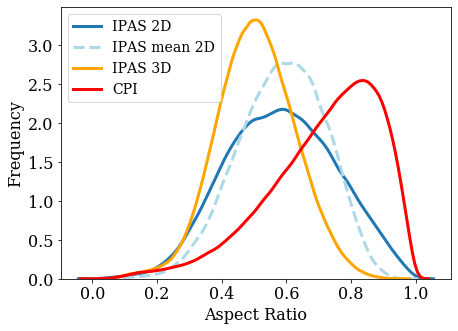

In [221]:
#phi2D and phi2Ds from 0.25-10.0, 30 monomers, r_m = 10
#agg_phi, 3D from database from 0.25-10.0, 30 monomers, all r_m
fig, ax = plt.subplots(figsize=(7,5))

sns.distplot(phi2D[:,:,:,:].flatten(), hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='IPAS 2D')
sns.distplot(phi2Ds[:,:,:,:].flatten(), hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle': '--', 'color': 'lightblue'}, label='IPAS mean 2D')
sns.distplot(ddf['agg_phi'][(ddf['mono_phi'] <= 10.0) & (ddf['mono_phi'] >= 0.25)], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'color': 'orange'}, label='IPAS 3D')
sns.distplot(df_CPI['phi_ellipse'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'color':'red'}, label='CPI')
ax.set(xlabel='Aspect Ratio', ylabel='Frequency');

In [240]:
df_CPI = pd.read_csv('final_databases/no_mask/all_campaigns.csv')

In [241]:
df_CPI_bullet = df_CPI[(df_CPI['classification'] == 'bullet')]

In [252]:
df_CPI_plate = df_CPI[(df_CPI['classification'] == 'plate')]

In [22]:
df_CPI_agg = df_CPI[(df_CPI['classification'] == 'agg')]

In [243]:
df_CPI_rimed_agg = df_CPI[(df_CPI['classification'] == 'rimed agg')]

In [244]:
df_CPI_compact = df_CPI[(df_CPI['classification'] == 'compact irregular')]

In [245]:
df_CPI_rimed_col = df_CPI[(df_CPI['classification'] == 'rimed column')]

In [246]:
df_CPI_column = df_CPI[(df_CPI['classification'] == 'column') | (df_CPI['classification'] == 'needle')]

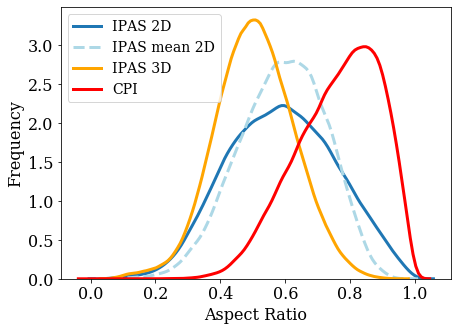

In [214]:
#phi2D and phi2Ds from 0.25-10.0, 30 monomers, r_m = 10
#agg_phi, 3D from database from 0.25-10.0, 30 monomers, all r_m
fig, ax = plt.subplots(figsize=(7,5))

sns.distplot(phi2D[1:-1,:,:,:].flatten(), hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='IPAS 2D')
sns.distplot(phi2Ds[1:-1,:,:,:].flatten(), hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle': '--', 'color': 'lightblue'}, label='IPAS mean 2D')
sns.distplot(ddf['agg_phi'][(ddf['mono_phi'] <= 10.0) & (ddf['mono_phi'] >= 0.25)], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'color': 'orange'}, label='IPAS 3D')
sns.distplot(df_CPI_rimed_agg['phi_ellipse'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'color':'red'}, label='CPI')
ax.set(xlabel='Aspect Ratio', ylabel='Frequency');

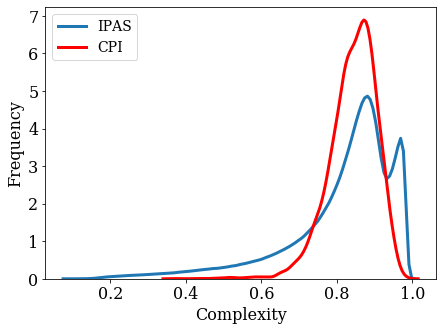

In [225]:
fig, ax = plt.subplots(figsize=(7,5))
sns.distplot(trunc['cplx'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='IPAS')
sns.distplot(df_CPI_rimed_col['complexity'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'color':'red'}, label='CPI')
ax.set(xlabel='Complexity', ylabel='Frequency');

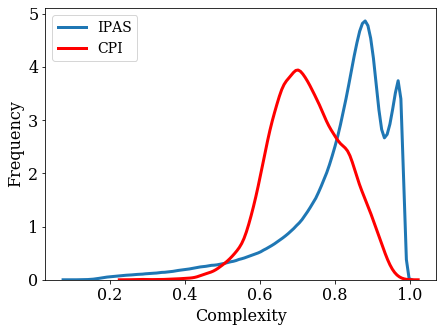

In [227]:
fig, ax = plt.subplots(figsize=(7,5))
sns.distplot(trunc['cplx'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='IPAS')
sns.distplot(df_CPI_column['complexity'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'color':'red'}, label='CPI')
ax.set(xlabel='Complexity', ylabel='Frequency');

In [20]:
#truncate # of monomers
trunc = ddf[(ddf['mono_phi'] > 0.01) & (ddf['mono_phi'] < 50) & (ddf['ncrystals'] < 20)]

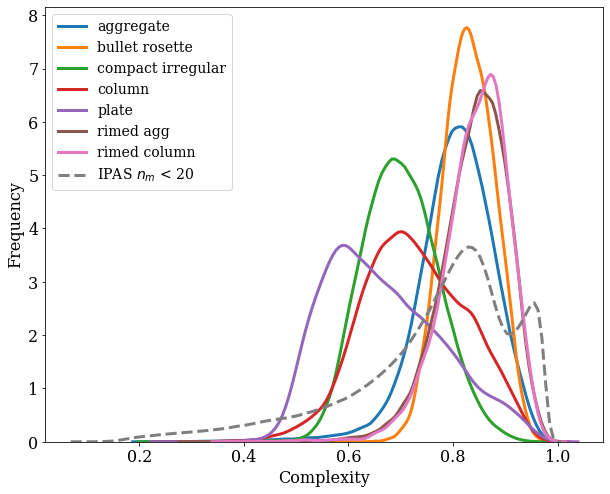

In [273]:
fig, ax = plt.subplots(figsize=(10,8))
sns.distplot(df_CPI_agg['complexity'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='aggregate')

sns.distplot(df_CPI_bullet['complexity'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='bullet rosette')

sns.distplot(df_CPI_compact['complexity'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='compact irregular')

sns.distplot(df_CPI_column['complexity'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='column')

sns.distplot(df_CPI_plate['complexity'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='plate')

sns.distplot(df_CPI_rimed_agg['complexity'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='rimed agg')

sns.distplot(df_CPI_rimed_col['complexity'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='rimed column')

sns.distplot(trunc['cplx'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle': '--'}, label='IPAS $n_m$ < 20')


ax.set(xlabel='Complexity', ylabel='Frequency');

/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/network/rit/lab/sulialab/share/bin/miniconda3/envs/pangeo/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


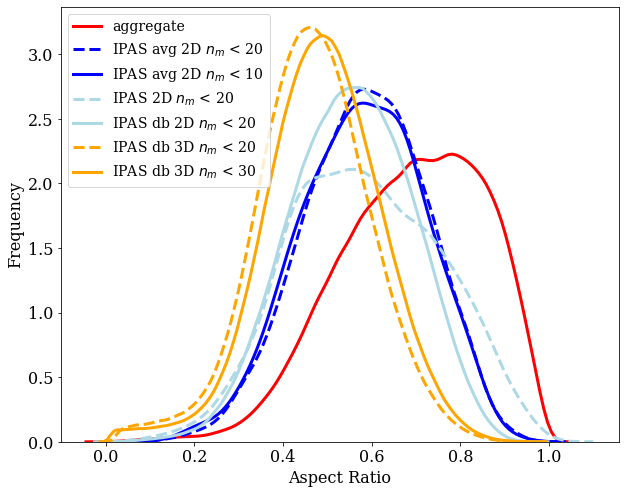

In [23]:
fig, ax = plt.subplots(figsize=(10,8))
sns.distplot(df_CPI_agg['phi_ellipse'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3,'color':'red'}, label='aggregate')

sns.distplot(phi2Ds[1:-1,:,:20].flatten(), hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle': '--','color':'blue'}, label='IPAS avg 2D $n_m$ < 20')

sns.distplot(phi2Ds[1:-1,:,:10].flatten(), hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3,'color':'blue'}, label='IPAS avg 2D $n_m$ < 10')

sns.distplot(phi2D[1:-1,:,:20].flatten(), hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle': '--','color':'lightblue'}, label='IPAS 2D $n_m$ < 20')

sns.distplot(trunc['phi2D'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3,'color':'lightblue'}, label='IPAS db 2D $n_m$ < 20')
#phi_m 0.01 and 50^
sns.distplot(trunc['agg_phi'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle': '--','color':'orange'}, label='IPAS db 3D $n_m$ < 20')
#phi_m 0.01 and 50^
sns.distplot(ddf['agg_phi'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3,'color':'orange'}, label='IPAS db 3D $n_m$ < 30')


ax.set(xlabel='Aspect Ratio', ylabel='Frequency');

In [278]:
trunc = ddf[(ddf['mono_phi'] > 0.01) & (ddf['mono_phi'] < 50) & (ddf['ncrystals'] < 10)]

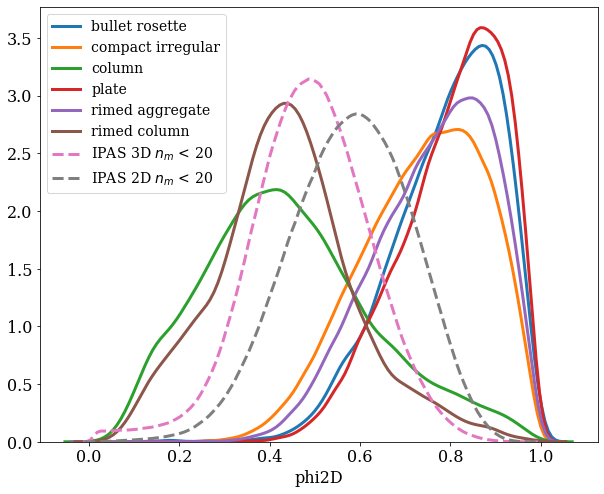

In [309]:
fig, ax = plt.subplots(figsize=(10,8))
#trunc = ddf[(ddf['mono_phi'] > 0.01) & (ddf['mono_phi'] < 50) & (ddf['ncrystals'] < 30)]
sns.distplot(df_CPI_bullet['phi_ellipse'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='bullet rosette')

sns.distplot(df_CPI_compact['phi_ellipse'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='compact irregular')

sns.distplot(df_CPI_column['phi_ellipse'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='column')

sns.distplot(df_CPI_plate['phi_ellipse'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='plate')

sns.distplot(df_CPI_rimed_agg['phi_ellipse'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='rimed aggregate')

sns.distplot(df_CPI_rimed_col['phi_ellipse'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3}, label='rimed column')

sns.distplot(ddf['agg_phi'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle': '--'}, label='IPAS 3D $n_m$ < 20')

sns.distplot(ddf['phi2D'], hist = False, kde = True, norm_hist=True,
             kde_kws = {'linewidth': 3, 'linestyle': '--'}, label='IPAS 2D $n_m$ < 20')
